<h1><center>Cyto_CommuGCN Tutorial</center></h1>

### Outline
1. Installation
2. Import modules
3. Read in spatial transcriptomics data
4. Integrate gene expression and cell-communication information into a Graph
5. Spatial domain detection using Cyto_CommuGCN
6. Calculate measurement 
7. Identify specific ligand-receptor pairs

### 1. Installation
To install Cyto_CommuGCN package you must make sure that your python version is over 3.8.=. If you don’t know the version of python you can check it by:

In [1]:
import platform
platform.python_version()

'3.9.19'

#### Anaconda
You could consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, Cyto (you can change to any name you like).

### 2. Import python modules

In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import anndata as ad
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
from sklearn import metrics
import Cyto_CommuGCN as ccgn

### 3. Read in data
You need to input three types of data: 
<br>
1. The gene expression matrix(n by k): expression_matrix.h5;
<br>
2. Spatial coordinateds of samplespositions.txt;
<br>
3. Ligand-Receptor information: histology.
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. 

In [3]:
# read data
file_fold = 'Data/Breast_data' #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
img=cv2.imread("Data/Breast_data/spatial/breast.tif")

In [4]:
adata.var_names_make_unique()
ccgn.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
ccgn.prefilter_specialgenes(adata)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4. Integrate gene expression and cell-cell communication into a Graph

In [5]:
x_array=adata.obs["array_row"].tolist()
y_array=adata.obs["array_col"].tolist()
x_pixel=adata.obsm['spatial'][:,1].tolist()
y_pixel=adata.obsm['spatial'][:,0].tolist()

x_pixel_list = x_pixel  
y_pixel_list = y_pixel

In [6]:
adj_Ed=ccgn.calculate_euclid_matrix(x=x_pixel_list,y=y_pixel_list)

In [7]:
adj_threshold=ccgn.calculate_adj_threshold(adj_Ed)

In [8]:
commu_matrix, G_C, L_R=ccgn.adj_commu(adata, lr_file_path="Data/L_R.xlsx", adj=adj_Ed, adj_r=adj_threshold)

### 5. Spatial domain detection using Cyto_CommuGCN

In [9]:
n_clusters=17
#Set seed
r_seed=t_seed=n_seed=140
#Search for suitable resolution
res=ccgn.search_res(adata,commu_matrix,n_clusters, start=0.5, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.5 step =  0.1
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Res =  0.5 Num of clusters =  11
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  12
Res changed to 0.6
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  14
Res changed to 0.7
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  17
recommended res =  0.7999999999999999


In [10]:
clf=ccgn.Cyto_CommuGCN()
#Set seed
r_seed=t_seed=n_seed=140          
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
os.environ['PYTHONHASHSEED']=str(n_seed)

#### 5.1 Run Cyto_CommuGCN

In [11]:
clf.train(adata,commu_matrix,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=500)

Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
delta_label  0.00315955766192733 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 43


#### 5.2 Plot spatial domains

In [12]:
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

In [13]:
# add ground_truth
df_meta = pd.read_csv('Data/Breast_data/metadata.tsv', sep='\t')
df_meta_layer = df_meta['fine_annot']
adata.obs['ground_truth'] = df_meta_layer.values
df_meta_layer_4 = df_meta['annot_four_type']
adata.obs['gt_4'] = df_meta_layer_4.values
df=adata.obs['gt_4']
mapping = {0: 'tumor_edge',1: 'Health', 3: 'DCIS/LCIS', 2: 'IDC'}
# 使用replace方法将列中的值替换
df = df.replace(mapping)
adata.obs['ground_truth_4']=df
adata.obs['ground_truth'] = adata.obs["ground_truth"].astype('category')
adata.obs['ground_truth_4'] = adata.obs["ground_truth_4"].astype('category')

# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['pred'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI


[<Axes: title={'center': 'Cyto-CommGCN ARI=0.6356'}, xlabel='spatial1', ylabel='spatial2'>]

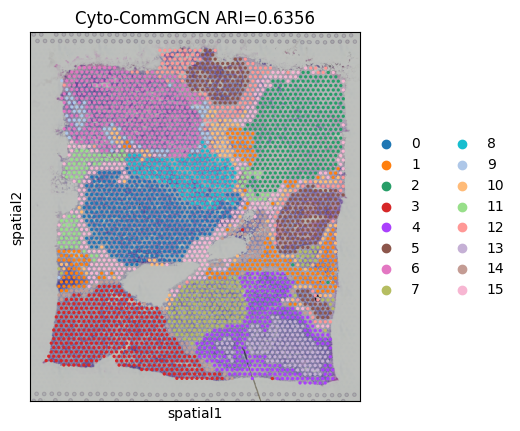

In [14]:
sc.pl.spatial(adata,img_key='hires',
              color=[ "pred"],
              title=["Cyto-CommGCN ARI=%.4f"%ARI],
              show=False)
#plt.savefig('/data/wolfking/fhj/Cyto_fhj/results/breast/breast.png', dpi=600)

In [15]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
sc.pl.spatial(adata,img_key='hires',
              color=["ground_truth_4"],
              title=["Ground_Truth"],
              palette=['forestgreen','Gold','red','steelblue'],
              show=False)
#plt.savefig('/data/wolfking/fhj/Cyto_fhj/results/breast/breast_groundtruth.png', dpi=600)

In [ ]:
.

### 6.Calculate measurement 

#### 6.1 Construct the ligand-receptor pairs and spot matrix.

In [ ]:
spot_list=adata.obs.index.tolist()
class_list=adata.obs['pred'].tolist()
name_list=L_R['L_R_pair'].tolist()
L_R_matrix= ccgn.interaction_score_matrix(adj_Ed, G_C, L_R)

In [ ]:
obs_data = {'name': spot_list,
            'class': class_list}
var_data = {'name': name_list}
obs_df = pd.DataFrame(obs_data)
obs_df.set_index(obs_df.columns[0], inplace=True)
var_df = pd.DataFrame(var_data)
var_df.set_index(var_df.columns[0], inplace=True)

adata_LR= ad.AnnData(X=L_R_matrix,
                     obs=obs_df,
                     var=var_df
                    )
adata_LR.obs['class'] = adata_LR.obs['class'].astype('category')
adata_LR.obs['ground_truth_4'] = adata.obs['ground_truth_4'].astype('category')
adata_LR.obs['x_pixel']=x_pixel
adata_LR.obs['y_pixel']=y_pixel
sc.pp.normalize_total(adata_LR, target_sum=1e4)
sc.pp.log1p(adata_LR)

#### 6.2 Identify secific ligand-receptor pairs

In [ ]:
sc.tl.rank_genes_groups(adata_LR, groupby='ground_truth_4', method='wilcoxon',pts=True)

In [ ]:
df_LR_de=sc.get.rank_genes_groups_df(adata_LR,group='tumor_edge')
df_LR_de= df_LR_de[df_LR_de['logfoldchanges']>1]
df_LR_de=df_LR_de[df_LR_de['pvals_adj']<0.05]

In [ ]:
df_LR_de

#### 6.3 Calculate and visualize communication score 

In [ ]:
adata_LR = ccgn.calculation_communication_score(adata_LR, adata)

In [ ]:
sc.pl.spatial(
    adata_LR,
    img_key='hires',
    color=["communication_score"],
    cmap='viridis',  # 可以根据需要选择其他颜色映射表
    show=False,
)